based on how long before the travel date 

# Build a product recommendation engine

This notebook contains steps and code to import user transaction *history from PostgresSQL, create hotel and car recommendation engines, and deploy these models to Watson Machine Learning. This notebook runs on Python 3.6 with Apache Spark 2.1.

*<i>The data in this code pattern is fake and does not involve any real purchase events</i>

## Learning Goals

The learning goals of this notebook are:

* Process the PostgresSQL data assets from the Object Storage service into a CSV file
* Load the CSV file into the Object Storage service linked to your Watson Studio
* Use the *k*-means algorithm, which is useful for cluster analysis in data mining, to segment customers leaving within the same time from booking to departure category into clusters for the purpose of finding relevant search results
* Deploy the model to the IBM Watson Machine Learning service in IBM Cloud to create your recommendation application

In the demo video, you can see the demo travel site [Bee Travels](http://bee-travels.v2.ibmdeveloper.net/) has hotel and car rental options. Users can filter hotels based on city, superchain, types, and time period of the trip. While car rentals in addition to the those parameters can also filter on body style. Data is aggregated in this notebook by customer ID and group, the amount of days before departure that the customer books the travel service. The group category as a customer identifier ensures the results are appropriate for their current needs.
<br><br>^^^^^**time frame instead of needs**??

#### <u>The video example of Bee Travels may provide you insight into the data you will encounter through this code pattern.</u>

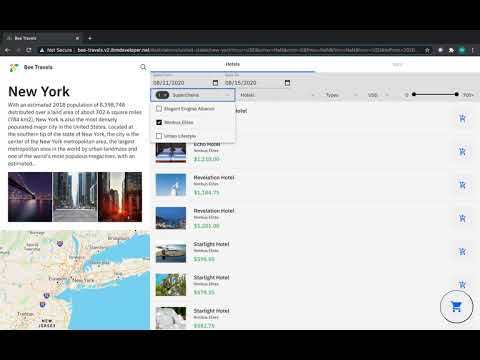

In [1]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('mcWI_KIn0sk')

## Table of contents

1. [Data Parameters](#dataparameters)<br>
2. [Setup](#setup)<br>
3. [Load and explore data](#load)<br>
4. [Create a KMeans model](#kmeans)<br>
   3.1. [Prepare data](#prepare_data)<br>
   3.2. [Create clusters and define the model](#build_model)<br>
5. [Persist the model](#persist)<br>
6. [Deploy the model to the cloud](#deploy)<br>
   5.1. [Create deployment for the model](#create_deploy)<br>
   5.2. [Test model deployment](#test_deploy)<br>
7. [Create product recommendations](#create_recomm)<br>
   6.1. [Test product recommendations model](#test_recomm)<br>
8. [Summary and next steps](#summary)<br>

<a id="dataparameters"></a>
## 1. Data Parameters

#### Car Data Variables

The other model trains on a data set with user transactions of car rentals with the following variables:
* Id: (type string) the customer ID of travelers with new and/or historical purchases
     <br><pre> Ex: b02b9dc9-673b-468f-ba2f-296d88e44429</pre>
* group: (type integer) the number of days before departure that the traveler books the car binned into categories 1-5 

where:


    - Group 1: represents < 3 days in advance    
    - Group 2: represents 3-6 days in advance
    - Group 3: represents 7-14 days in advance
    - Group 4: represents 15-29 days in advance
    - Group 5: represents 30 or greater days in advance
    
- rent-pad, capsule, rentio, chakra, carlux: (type integer) car rental companies, containing 1 or 0 where:

      - 1 represents the rental company was booked during a transaction, for each transaction (row of data) 
          there is only one rental company booking
      - 0 represents the rental companies that were not booked during a transaction
    
* sedan, suv, hatchback, muscle, crossover, convertible, sports: (type integer) car body type, containing 1 or 0 

where:

     - 1 represents the body type purchased, for each transaction (row of data) there is only one body style
         given 1
     - 0 represents the body styles that were not booked during a transaction
    
* basic, luxury, comfort: (type integer) car style, containing 1 or 0 where:

      - 1 represents the style purchased, for each transaction (row of data) there is only one style give 1
      - 0 represents the styles that were not booked during a transaction

#### Hotel Data Variables

The other model trains on a data set with user transactions of car rentals with the following variables:
* Id: (type string) the customer ID of travelers with new and/or historical purchases
     <br><pre> Ex: b02b9dc9-673b-468f-ba2f-296d88e44429</pre>
* group: (type integer) the number of days before departure that the traveler books the hotel binned into categories 1-5 where:
 

where:


    - Group 1: represents < 3 days in advance    
    - Group 2: represents 3-6 days in advance
    - Group 3: represents 7-14 days in advance
    - Group 4: represents 15-29 days in advance
    - Group 5: represents 30 or greater days in advance
    
- nimbus-elites, elegant-enigma-alliance, urban-lifestyle: (type integer) hotel chain companies containing 1 or 0 where:

      - 0 represents the hotel chains that were not booked during a transaction
      - 1 represents the hotel chain was booked during a transaction, for each transaction (row of data) there is only one chain booked
    
* budget, luxury, comfort: (type integer) hotels are labeled by these user priorities, containing 1 or 0 where:

      - 0 represents the priorities that were not booked during a transaction
      - 1 represents the priority booked during a transaction, for each transaction (row of data) there is only 
        one priority selected

<a id="setup"></a>
## 2. Setup


Before you use the sample code in this notebook, you must perform the following setup tasks:

* Understand the data characteristics for each of the two recommendation systems present in this code pattern
* Create a Watson Machine Learning service instance (a free plan is offered) and associate it with your project


We'll be using a few libraries for this exercise:

1. [Watson Machine Learning Client](http://wml-api-pyclient.mybluemix.net/): Client library to work with the Watson Machine Learning service on IBM Cloud. Library available on [pypi](https://pypi.org/project/watson-machine-learning-client/). Service available on [IBM Cloud](https://cloud.ibm.com/catalog/services/machine-learning).
1. [Pixiedust](https://github.com/pixiedust/pixiedust): Python Helper library for Jupyter Notebooks. Available on [pypi](https://pypi.org/project/pixiedust/).
1. [ibmos2spark](https://github.com/ibm-watson-data-lab/ibmos2spark): Facilitates Data I/O between Spark and IBM Object Storage services

In [ ]:
!pip install --upgrade ibmos2spark
!pip install --upgrade pixiedust
!pip install --upgrade watson-machine-learning-client

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import pixiedust

In [ ]:
pixiedust.optOut() #opt out of Pixie Dust collecting your data

<a id="load"></a>
## 3. Load and explore data

In this section you will load the CSV data file that contains the car rental transaction history using PixieDust's [`sampleData`](https://pixiedust.github.io/pixiedust/loaddata.html) method:

In [ ]:
#loads the data as a CSV from Github as a raw file
sparkDataFrame = pixiedust.sampleData('https://raw.githubusercontent.com/mhrosen/recommendation-code-pattern/master/notebook/data%20assets/cars_csv_uid.csv')



To better examine and visualize the data, run the following cell to view it in a table format. Note that Pixiedust's `display` method can also render data using various chart types, such as pie charts, line graphs, and scatter plots.

In [ ]:
display(sparkDataFrame)

<a id="kmeans"></a>
## 4. Create a *k*-means model with Spark

In this section of the notebook you use the *k*-means implementation to associate every customer to a cluster based on their transaction data based on the amount of days before departure that the customer books their car rentals.

First, import the Apache Spark Machine Learning packages ([MLlib](http://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html)) that you need in the subsequent steps:


In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.clustering import KMeansModel
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors

<a id="prepare_data"></a>
### 4.1 Prepare data

In this data set we are already given the columns you need. If you try to edit this model to work with a different data set, make sure you filter the data down to only the columns you need, removing columns that you do not wish to aggregate and train the model with. 

In [ ]:
## Here are the car cols we wish to train the model with. 
cars_cols = ["rent-pad","capsule","rentio","chakra","carlux","sedan","suv","hatchback","muscle","crossover","convertible","sports","basic","premium","luxury"]

Now, aggregate the individual transactions for each customer within each group category timeframe to get a single score per car rental company, body type, and style per customer. If the data is aggregated correctly, each customer ID should map to any given group no more than once. 

In [ ]:
df_city_daysBeforeDeparture = sparkDataFrame.groupby(['id','group']).sum()
df_city_daysBeforeDeparture = df_city_daysBeforeDeparture.drop('sum(group)') 
#you do not want this column "group" to be passed as a feature because we are interested in selecting recommendations
#for customers based on their history (and history if similar customers) within their booking-to-departure time period category


display(df_city_daysBeforeDeparture)

<a id="build_model"></a>
### 4.2 Create clusters and define the model 

Create 50 clusters with a *k*-means model based on the features of a car that a specific customer books within their respective based on their booking timeframe category.



> If you wish to find how many k clusters to run for a new data set, use the elbow method to find where a bend in the curve may occur.<br><br>
> **<u>Warning:</u> _Should you decide to try adding the Elbow Method: DO NOT RUN TOO MANY SPARK JOBS, RUN FOR A FEW ITERATIONS AT A TIME AND STORE THE COST VALUES IN A TXT OR CSV FILE_**



|No Clustering | Clustering |
|------|------|
|  ![](https://raw.githubusercontent.com/IBM/product-recommendation-with-watson-ml/master/doc/source/images/kmeans-1.jpg)  | ![](https://raw.githubusercontent.com/IBM/product-recommendation-with-watson-ml/master/doc/source/images/kmeans-2.jpg) |


First, create a feature vector by combining each car rental company, body type, and style (basic, premium, luxury) columns:

In [ ]:
assembler = VectorAssembler(inputCols=["sum({})".format(x) for x in cars_cols],outputCol="features") # Assemble vectors using product fields
df_kmeans = assembler.transform(df_city_daysBeforeDeparture)
display(df_kmeans)

In [ ]:
df_city_daysBeforeDeparture = model.transform(df_city_daysBeforeDeparture) #predictions


display(df_city_daysBeforeDeparture)

<a id="persist"></a>
## 5. Persist the model 

In this section you will learn how to store your pipeline and model in Watson Machine Learning repository by using Python client libraries.

### 5.1 Configure IBM Watson Machine Learning credentials

To access your machine learning repository programmatically, you need to copy in your credentials, which you can see in your **IBM Watson Machine Learning** service details in IBM Cloud.

> **IMPORTANT**: Update `apikey` and `instance_id` below. Credentials can be found on _Service Credentials_ tab of the Watson Machine Learning service instance created on the IBM Cloud.
> To access _Service Credentials_ 
> 1. Go to [cloud.ibm.com](cloud.ibm.com) and login

> ![Credentials_Step1](https://github.com/mhrosen/recommendation-code-pattern/blob/master/notebook/images-for-bee-travels-notebook/Credentials1.jpeg)


> 2. Click on _Services_, search the name of your Watson instance, and click on it

> ![Credentials_Step2](https://github.com/mhrosen/recommendation-code-pattern/blob/master/notebook/images-for-bee-travels-notebook/Credentials2.jpeg)


> 3. Select _Service Credentials_ on the left panel

> ![Credentials_Step3](https://github.com/mhrosen/recommendation-code-pattern/blob/master/notebook/images-for-bee-travels-notebook/Credentials3.jpeg)

In [ ]:
# @hidden_cell
#<<<<<*****>>>>> appears 4 times and represents individual credential information
wml_credentials = {
  "apikey": "<<<<<*****>>>>>",
  "iam_apikey_description": "Auto-generated for <<<<<*****>>>>>",
  "iam_apikey_name": "<<<<<*****>>>>>",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/<<<<<*****>>>>>",
  "instance_id": "<<<<<*****>>>>>",
  "url": "https://us-south.ml.cloud.ibm.com"
}
print(wml_credentials)

In [ ]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient
client = WatsonMachineLearningAPIClient(wml_credentials)
print(client.version)

### 5.2 Save the model 

#### Save the model to the Watson Machine Learning repository

You use the Watson Machine Learning client's [Repository class](http://wml-api-pyclient.mybluemix.net/#repository) to store and manage models in the Watson Machine Learning service. 

> **NOTE**: You can also use Watson Studio to manage models. In this notebook we are using the client library instead.

In [ ]:
train_data = df_city_daysBeforeDeparture.withColumnRenamed('id', 'label')

> **TIP**: Update the cell below with the name you wish to give to your model.

In [2]:
model_props = { client.repository.ModelMetaNames.NAME: "bee-travels-car-recommendation"}
published_model = client.repository.store_model(model=model, pipeline=pipeline, meta_props=model_props, training_data=train_data)

NameError: name 'client' is not defined

> **NOTE**: You can delete a model from the repository by calling `client.repository.delete(<ENTER GUID>)`.

#### Display list of existing models in the Watson Machine Learning repository 

In [ ]:
client.repository.list_models()

#### Display information about the saved model

In [ ]:
import json
saved_model_uid = client.repository.get_model_uid(published_model)
model_details = client.repository.get_details(saved_model_uid)
print(json.dumps(model_details, indent=2))

<a id="deploy"></a>
## 6. Deploy model to the IBM cloud

You use the Watson Machine Learning client's [Deployments class](http://wml-api-pyclient.mybluemix.net/#deployments) to deploy and score models.

### 6.1 Create an online deployment for the model

In [ ]:
created_deployment = client.deployments.create(saved_model_uid, 'car-recommendation-model')

### 6.2 Retrieve the scoring endpoint for this model

In [ ]:
scoring_endpoint = client.deployments.get_scoring_url(created_deployment)
print(scoring_endpoint)

<a id="test_deploy"></a>
### 6.3 Test the deployed model

To verify that the model was successfully deployed to the cloud, you'll specify a customer ID, for example customer 222f62f8-9941-4148-a9f6-cf887db1dede 's group 4 profile, to predict this customer's cluster against the Watson Machine Learning deployment, and see if it matches the cluster that was previously associated this customer ID.

In [ ]:
customer_group4 = df_city_daysBeforeDeparture_cluster.filter("id='222f62f8-9941-4148-a9f6-cf887db1dede'").filter("group=4").collect()
print("Previously calculated cluster = {}".format(customer_group4[0].cluster))

To determine the customer's cluster using Watson Machine Learning, you need to load the customer's purchase history. This function uses the local data frame to select every car rental field and the amount of time before departure that customer 222f62f8-9941-4148-a9f6-cf887db1dede, when in group 4, booked a car.

In [ ]:
from six import iteritems
def get_rental_counts_for_customer(identifier group):
    cust = df_city_daysBeforeDeparture.filter("id='{}'".format(identifier)).filter("group={}".format(group)).take(1)
    fields = []
    values = []
    for row in customer:
        for car_col in cars_cols:
            field = 'sum({})'.format(car_col)
            value = row[field]
            fields.append(field)
            values.append(value)
    return (fields, values)

In [ ]:
get_rental_counts_for_customer('222f62f8-9941-4148-a9f6-cf887db1dede', 4)

This function takes the customer's purchase history and calls the scoring endpoint:

In [ ]:
def get_cluster_from_watson_ml(fields, values):
    scoring_payload = {'fields': fields, 'values': [values]}
    predictions = client.deployments.score(scoring_endpoint, scoring_payload) 
    return predictions['values'][0][len(cars_cols)+1]

Finally, call the functions defined above to get the rental booking history, call the scoring endpoint, and get the cluster associated to customer 222f62f8-9941-4148-a9f6-cf887db1dede when booking within the group 4 timeframe:

In [ ]:
rental_counts = get_product_counts_for_customer('222f62f8-9941-4148-a9f6-cf887db1dede', 4)
fields = rental_counts[0]
values = rental_counts[1]
print(fields, values)
print("Cluster calculated by Watson ML = {}".format(get_cluster_from_watson_ml(fields, values)))

<a id="create_recomm"></a>
## 7. Create car rental recommendations

Now you can create some car rental recommendations.

First, run this cell to create a function that queries the database and finds the most popular items for a cluster. In this case, the **df_city_daysBeforeDeparture_cluster** dataframe is the database.

In [ ]:
# This function gets the most popular clusters in the cell by grouping by the cluster column
def get_popular_rentals_in_cluster(cluster):
    df_cluster_cities = df_city_daysBeforeDeparture_cluster.filter('cluster = {}'.format(cluster))
    df_cluster_cities_agg = df_cluster_cities.groupby('cluster').sum()
    row = df_cluster_cities_agg.rdd.collect()[0]
    items = []
    for car_col in cars_cols:
        field = 'sum(sum({}))'.format(car_col)
        items.append((car_col, row[field]))
    sortedItems = sorted(items, key=lambda x: x[1], reverse=True) # Sort by score
    popular = [x for x in sortedItems if x[1] > 0]
    print(popular)
    return popular

Now, run this cell to create a function that will calculate the recommendations based on a given cluster. This function finds the most popular car rentals in the cluster, filters out rentals already purchased by the customer, and finally produces a list of recommended rentals.

In [ ]:
# This function takes a cluster and the history of every car rentals already purchased
from pyspark.sql.functions import desc
def get_recommendations_by_cluster(cluster):
    # Existing customer rental cars
#     print('RENTAL CAR HISTORY:')
#     customer_products = []
#     for i in range(0, len(cars_cols)):
#         if purchased_quantities[i] > 0:
#             customer_products.append((cars_cols[i], purchased_quantities[i]))
#     df_city_daysBeforeDeparture = sc.parallelize(customer_products).toDF(["PRODUCT","COUNT"])
#     df_city_daysBeforeDeparture.show()
    # Get popular products in the cluster
    print('POPULAR PRODUCTS IN CLUSTER:')
    cluster_products = get_popular_products_in_cluster(cluster)
    df_cluster_products = sc.parallelize(cluster_products).toDF(["PRODUCT","COUNT"])
    df_cluster_products.show()
    # Filter out products the user has already purchased
#     print('RECOMMENDED PRODUCTS:')
#     df_recommended_products = df_cluster_products.alias('cl').join(df_city_daysBeforeDeparture.alias('cu'), df_city_daysBeforeDeparture['PRODUCT'] == df_city_daysBeforeDeparture'PRODUCT'], 'leftouter')
#     df_recommended_products = df_recommended_products.filter('cu.PRODUCT IS NULL').select('cl.PRODUCT','cl.COUNT').sort(desc('cl.COUNT'))
#     df_recommended_products.show(10)

In [ ]:
get_recommendations_by_cluster(rental_counts)

Now, run this cell to create a function that will calculate the recommendations based on a given cluster. This function finds the most popular products in the cluster, filters out products already purchased by the customer or currently in the customer's shopping cart, and finally produces a list of recommended products.



In [ ]:
his function takes a cluster and the quantity of every product already purchased or in the user's cart
from pyspark.sql.functions import desc
def get_recommendations_by_cluster(cluster, purchased_quantities):
    # Existing customer products
    print('PRODUCTS ALREADY PURCHASED/IN CART:')
    customer_products = []
    for i in range(0, len(product_cols)):
        if purchased_quantities[i] > 0:
            customer_products.append((product_cols[i], purchased_quantities[i]))
    df_customer_products = sc.parallelize(customer_products).toDF(["PRODUCT","COUNT"])
    df_customer_products.show()
    # Get popular products in the cluster
    print('POPULAR PRODUCTS IN CLUSTER:')
    cluster_products = get_popular_products_in_cluster(cluster)
    df_cluster_products = sc.parallelize(cluster_products).toDF(["PRODUCT","COUNT"])
    df_cluster_products.show()
    # Filter out products the user has already purchased
    print('RECOMMENDED PRODUCTS:')
    df_recommended_products = df_cluster_products.alias('cl').join(df_customer_products.alias('cu'), df_cluster_products['PRODUCT'] == df_customer_products['PRODUCT'], 'leftouter')
    df_recommended_products = df_recommended_products.filter('cu.PRODUCT IS NULL').select('cl.PRODUCT','cl.COUNT').sort(desc('cl.COUNT'))
    df_recommended_products.show(10)

Next, run this cell to create a function that produces a list of recommended items based on the products and quantities in a user's cart. This function uses Watson Machine Learning to calculate the cluster based on the shopping cart contents and then calls the get_recommendations_by_cluster function.

In [ ]:
# This function would be used to find recommendations based on the products and quantities in a user's cart
def get_recommendations_for_shopping_cart(products, quantities):
    fields = []
    values = []
    for product_col in product_cols:
        field = 'sum({})'.format(product_col)
        if product_col in products:
            value = quantities[products.index(product_col)]
        else:
            value = 0
        fields.append(field)
        values.append(value)
    return get_recommendations_by_cluster(get_cluster_from_watson_ml(fields, values), values)

Run this cell to create a function that produces a list of recommended items based on the purchase history of a customer. This function uses Watson Machine Learning to calculate the cluster based on the customer's purchase history and then calls the get_recommendations_by_cluster function.

In [ ]:
# This function is used to find recommendations based on the purchase history of a customer
def get_recommendations_for_customer_purchase_history(customer_id):
    product_counts = get_product_counts_for_customer(customer_id)
    fields = product_counts[0]
    values = product_counts[1]
    return get_recommendations_by_cluster(get_cluster_from_watson_ml(fields, values), values)

Now you can take customer 12027 and produce a recommendation based on that customer's purchase history:

In [ ]:
get_recommendations_for_customer_purchase_history(12027)


Now, take a sample shopping cart and produce a recommendation based on the items in the cart:

In [ ]:
get_recommendations_for_shopping_cart(['Diapers','Baby wash','Oatmeal'],[1,2,1])

6.1 Test product recommendations model
You can interactively test your product recommendations model using a simple PixieApp. PixieApps encapsulate business logic and data visualizations, making it easy for notebook users to explore data without having to write any code. Typically these applications are pre-packaged and imported into a notebook. However, for illustrative purposes we've embedded the product recommendation source code in this notebook.



Run the cell below, add items to the shopping cart and click the Refresh button to review the recommendation results.

In [ ]:
# This function takes a cluster and the quantity of every product already purchased or in the user's cart & returns the data frame of recommendations for the PixieApp
from pyspark.sql.functions import desc
def get_recommendations_by_cluster_app(cluster, purchased_quantities):
    # Existing customer products
    customer_products = []
    for i in range(0, len(product_cols)):
        if purchased_quantities[i] > 0:
            customer_products.append((product_cols[i], purchased_quantities[i]))
    df_customer_products = sc.parallelize(customer_products).toDF(["PRODUCT","COUNT"])
    # Get popular products in the cluster
    cluster_products = get_popular_products_in_cluster(cluster)
    df_cluster_products = sc.parallelize(cluster_products).toDF(["PRODUCT","COUNT"])
    # Filter out products the user has already purchased
    df_recommended_products = df_cluster_products.alias('cl').join(df_customer_products.alias('cu'), df_cluster_products['PRODUCT'] == df_customer_products['PRODUCT'], 'leftouter')
    df_recommended_products = df_recommended_products.filter('cu.PRODUCT IS NULL').select('cl.PRODUCT','cl.COUNT').sort(desc('cl.COUNT'))
    return df_recommended_products


# PixieDust sample application

from pixiedust.display.app import *

@PixieApp
class RecommenderPixieApp:
    def setup(self):
        self.product_cols = product_cols
        
    def computeUserRecs(self, shoppingcart):   
        #format products and quantities from shopping cart display data
        lst = list(zip(*[(item.split(":")[0],int(item.split(":")[1])) for item in shoppingcart.split(",")]))
        products = list(lst[0])
        quantities = list(lst[1])
        #format for the Model function
        lst = list(zip(*[('sum({})'.format(item),quantities[products.index(item)] if item in products else 0) for item in self.product_cols]))
        fields = list(lst[0])
        values = list(lst[1])
        #call the run Model function
        recommendations_df = get_recommendations_by_cluster_app(get_cluster_from_watson_ml(fields, values), values)
        recs = [row["PRODUCT"] for row in recommendations_df.rdd.collect()]
        return recs[:5]
    
    @route(shoppingCart="*")
    def _recommendation(self, shoppingCart):
        recommendation = self.computeUserRecs(shoppingCart)
        self._addHTMLTemplateString(
        """
        <table style="width:100%"> {% for item in recommendation %} <tr> <td type="text" style="text-align:left">{{item}}</td> </tr> {% endfor %} </table>
        """, recommendation = recommendation)

        
    @route()
    def main(self):
        return """
        <script>
        function getValuesRec(){
            return $( "input[id^='prod']" )
            .filter(function( index ) {
                return parseInt($(this).val()) > 0;})
            .map(function(i, product) {
                return $(product).attr("name") + ":" + $(product).val();
            }).toArray().join(",");}
            
        function getValuesCart(){
            return $( "input[id^='prod']" )
            .filter(function( index ) {
                return parseInt($(this).val()) > 0; })
            .map(function(i, product) {
                return $(product).attr("name") + ":" + $(product).val();
            }).toArray(); }
        
        function populateCart(field) {
            user_cart = getValuesCart();
            $("#user_cart{{prefix}}").html("");
            if (user_cart.length > 0) {
                for (var i in user_cart) {
                    var item = user_cart[i];
                    var item_arr = item.split(":")
                    $("#user_cart{{prefix}}").append('<tr><td style="text-align:left">'+item_arr[1]+" "+item_arr[0]+"</td></tr>"); } }
            else { $("#user_cart{{prefix}}").append('<tr><td style="text-align:left">'+ "Cart Empty" +"</td></tr>"); } }
        
        function increase_by_one(field) {
            nr = parseInt(document.getElementById(field).value);
            document.getElementById(field).value = nr + 1;
            populateCart(field); }
        
        function decrease_by_one(field) {
            nr = parseInt(document.getElementById(field).value);
            if (nr > 0) { if( (nr - 1) >= 0) { document.getElementById(field).value = nr - 1; } }
            populateCart(field); } 
        </script>
        
        <table> Products: {% for item in this.product_cols %}
            {% if loop.index0 is divisibleby 4 %} <tr> {% endif %}
                <div class="prod-quantity">
                <td class="col-md-3">{{item}}:</td><td><input size="2" id="prod{{loop.index}}{{prefix}}" class="prods" type="text" 
                    style="text-align:center" value="0" name="{{item}}" /></td>
                <td><button onclick="increase_by_one('prod{{loop.index}}{{prefix}}');">+</button></td>
                <td><button onclick="decrease_by_one('prod{{loop.index}}{{prefix}}');">-</button></td>
                </div>
            {% if ((not loop.first) and (loop.index0 % 4 == 3)) or (loop.last) %} </tr> {% endif %}
        {% endfor %} </table>
        
        <div class="row">
            <div class="col-sm-6"> Your Cart: </div>
            <div class="col-sm-6"> Your Recommendations: <button pd_options="shoppingCart=$val(getValuesRec)" pd_target="recs{{prefix}}"> 
                <pd_script type="preRun"> if (getValuesRec()==""){alert("Your cart is empty");return false;} return true;
                </pd_script>Refresh </button> 
            </div>
        </div>
        
        <div class="row">
        <div class="col-sm-3"> <table style="width:100%" id="user_cart{{prefix}}"> </table> </div> <div class="col-sm-3"> </div>
        <div class="col-sm-3" id="recs{{prefix}}" pd_loading_msg="Calling your model in Watson ML"></div> <div class="col-sm-3"> </div>
        </div>
        """
        
    

#run the app
RecommenderPixieApp().run(runInDialog='false')


<font color=green>Congratulations</font>, you've sucessfully created a recommendation engine, deployed it to the Watson Machine Learning service, and created a PixieApp!
You can now switch to the Watson Machine Learning console to deploy the model and then test it in application, or continue within the notebook to deploy the model using the APIs.